In [1]:
SEED = 99999

import os,gc,sys
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
## pip install -U --pre efficientnet
import efficientnet.tfkeras as efn 
from functools import partialmethod
import transformers
from transformers.optimization_tf import AdamWeightDecay
from sklearn.model_selection import StratifiedKFold, train_test_split
from PIL import Image
import pandas as pd
import math

print('TF version',tf.__version__)

TF version 2.0.0


In [2]:
input_dir = '..input/'
model_dir = './models/'
EPOCHS = 80 
BATCH_SIZE =  64
LABEL_SMOOTHING = 0.15
epochs_for_first_cycle = 10
initial_lr = 3e-5
IMG_SHAPE = (224,224)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_df = pd.read_csv(input_dir+'train.csv').fillna('')
sub_test_df = pd.read_csv(input_dir+'test.csv').fillna('')

In [3]:
#input_dir + 'train/train/' +  ###input_dir + 'test/test/' +
train_df["path"] = train_df["category"]\
                    .map(lambda x: input_dir + 'train/train/' +str(x).zfill(2)+"/") \
                    + train_df["filename"]
sub_test_df["path"] = sub_test_df["filename"].map(lambda x: input_dir + 'test/test/' +x)
sub_test_df["category"]=None
train_df["category"] = train_df["category"].map(lambda x: str(x).zfill(2))

In [4]:
train_ids, test_ids, _, _ = train_test_split(train_df.index.values, train_df.category, \
                                                    test_size=0.1, random_state=SEED,\
                                                    stratify=train_df.category)

In [5]:

test_datagen = ImageDataGenerator(rescale=1. / 255)
submission_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_dataframe(
    train_df.loc[test_ids,:], directory=input_dir , x_col='path', y_col='category', weight_col=None,
    target_size=IMG_SHAPE, color_mode='rgb',class_mode='categorical', 
    batch_size=BATCH_SIZE, shuffle=False, seed=SEED,
    interpolation='nearest', validate_filenames=False, 
    )

submission_generator = submission_datagen.flow_from_dataframe(
    sub_test_df, directory=input_dir , x_col='path', y_col='category', weight_col=None,
    target_size=IMG_SHAPE, color_mode='rgb',class_mode=None, 
    batch_size=BATCH_SIZE, shuffle=False, seed=SEED,
    interpolation='nearest', validate_filenames=False, 
    )

class_weight = {v:1.0 for v in range(42)}
class_weight[0]=2.0
class_weight[1]=2.0
class_weight[2]=2.0
class_weight[3]=2.0
class_weight[20]=2.0
class_weight[36]=2.0
class_weight[41]=2.0


Found 10540 non-validated image filenames belonging to 42 classes.
Found 12186 non-validated image filenames.


In [6]:
train_file_list = tf.data.Dataset.from_tensor_slices(train_df.loc[train_ids,"path"])
train_size = len(train_df.loc[train_ids,"path"])
classes = {str(v).zfill(2):v for v in range(42)}
NO_CLASSES = len(classes)
inv_class_map = {v: k for k, v in classes.items()}


def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == list(classes.keys())
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.    
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SHAPE[0], IMG_SHAPE[1]])
    #augment
    img = tf.image.random_brightness(img, 0.4, seed=SEED)
    img = tf.image.random_contrast(img, 0.2, 0.5, seed=SEED)
    img = tf.image.random_crop(img, [200, 200, 3], seed=SEED)
    img = tf.image.random_flip_left_right(img, seed=SEED)
    img = tf.image.random_flip_up_down(img,seed=SEED)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_SHAPE[0], IMG_SHAPE[1]])
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, cache="./cache.temp", shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    #ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_file_ds = train_file_list.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = prepare_for_training(train_labeled_file_ds,cache=True)


In [7]:
def scheduler(epoch):
    #return 3e-5 * 0.75**(epoch-epochs_for_first_cycle)
    return 3e-6


def loss_with_ls(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, \
                                                    label_smoothing=LABEL_SMOOTHING)
def build_model(update_model=None):
    
    #optimizer
    AdamWeightDecay.apply_gradients = partialmethod(AdamWeightDecay.apply_gradients, clip_norm=1.0)
    lr_schedule = tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=initial_lr, \
                                                        first_decay_steps=700, t_mul=2.0, m_mul=0.85, alpha=0.01)    
    lr_schedule = transformers.optimization_tf.WarmUp(initial_learning_rate=initial_lr, 
                                                      decay_schedule_fn=lr_schedule, warmup_steps=100)
    optimizer = AdamWeightDecay(learning_rate=lr_schedule,weight_decay_rate=0.003)
    
    if update_model != None:
        update_model.trainable = True
        for layer in update_model.layers:
            layer.trainable = False
            if (layer.name=='block3a_expand_conv'):
                layer.trainable = True
                break
        update_model.compile(optimizer=optimizer, loss=loss_with_ls, metrics=['accuracy'])
        print("trainable layers",len(update_model.trainable_variables))
        return update_model
    
    base_model = efn.EfficientNetB5(input_shape=IMG_SHAPE+(3,),
                                    weights='noisy-student',include_top=False)   
    base_model.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(NO_CLASSES,activation="softmax")(x)
    
    model = tf.keras.Model(base_model.input, x)  
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    print("trainable layers",len(model.trainable_variables))
    return model

#build_model().summary

In [8]:
DISPLAY = 1
train_probabs = np.zeros((train_df.shape[0],NO_CLASSES),dtype='float32')
submission_probabs = np.zeros((sub_test_df.shape[0],NO_CLASSES),dtype='float32')

print('#'*25)
print("### Training")
print('#'*25)
model_save = model_dir+'eff_b4.h5'
model_save2 = model_dir+'eff_b4_tuned.h5'
K.clear_session()

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler,\
                                                     verbose=DISPLAY)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001,
                                   patience=5, verbose=DISPLAY, mode='auto')    
sv = tf.keras.callbacks.ModelCheckpoint(model_save2, \
                                        monitor='val_loss', verbose=1, save_best_only=True,\
                                        save_weights_only=True, mode='auto', save_freq='epoch')


model = build_model()
model = build_model(model)
model.load_weights(model_save)

## train only top classifier
# model.fit(train_ds,epochs=epochs_for_first_cycle,
#           verbose=DISPLAY, callbacks=[],steps_per_epoch=train_size//BATCH_SIZE , #steps_per_epoch=5,
#             validation_data=test_generator,shuffle=False,class_weight=class_weight)

print("unfreezing few more layers and finetuning")
# unfreeze a few more layers and train till convergence
#model = build_model(model)
history = model.fit(train_ds,epochs=EPOCHS, initial_epoch = epochs_for_first_cycle,  
          verbose=DISPLAY, callbacks=[early_stopping, sv],steps_per_epoch=train_size//BATCH_SIZE,
          validation_data=test_generator,shuffle=False,class_weight=class_weight)

print('Loading model...')
model.load_weights(model_save2)

print('Predicting Test...')
train_probabs[test_ids,] += model.predict(test_generator,verbose=DISPLAY)
model.evaluate(test_generator,verbose=DISPLAY)

print('Predicting submission...')
submission_probabs += model.predict(submission_generator,verbose=DISPLAY)


#########################
### Training
#########################
trainable layers 2
trainable layers 343
unfreezing few more layers and finetuning
Train for 1482 steps, validate for 165 steps
Epoch 14/80
1481/1482 [============================>.] - ETA: 0s - loss: 1.4038 - accuracy: 0.8412
Epoch 00014: val_loss improved from inf to 1.54917, saving model to ./models/eff_b4_tuned.h5
1482/1482 [==============================] - 788s 531ms/step - loss: 1.4038 - accuracy: 0.8412 - val_loss: 1.5492 - val_accuracy: 0.7897
Epoch 15/80
1481/1482 [============================>.] - ETA: 0s - loss: 1.3411 - accuracy: 0.8676
Epoch 00015: val_loss did not improve from 1.54917
1482/1482 [==============================] - 735s 496ms/step - loss: 1.3410 - accuracy: 0.8676 - val_loss: 1.5560 - val_accuracy: 0.7910
Epoch 16/80
1481/1482 [============================>.] - ETA: 0s - loss: 1.3071 - accuracy: 0.8814
Epoch 00016: val_loss did not improve from 1.54917
1482/1482 [==============================]

In [9]:
test_result_probabs = train_probabs[test_ids,]  ## real values in train_df.loc[test_ids,"category"]
submission_probabs = submission_probabs

In [10]:
### apply argmax
### evaluate results of cv and test
np.save('b4_probabs.npy', submission_probabs)
# np.save('test_result_probabs.npy', test_result_probabs)

In [11]:
#cv_result_thresh = np.argmax(cv_result_probabs,axis=1)
submission_thresh = np.argmax(submission_probabs,axis=1)
test_result_thresh = np.argmax(test_result_probabs,axis=1)

In [12]:
sub_test_df.loc[:,"category"]=submission_thresh
sub_test_df.loc[:,"category"] =sub_test_df.loc[:,"category"].map(lambda x: str(x).zfill(2))
sub_test_df[["filename","category"]].to_csv("submssion.csv",index=False)

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

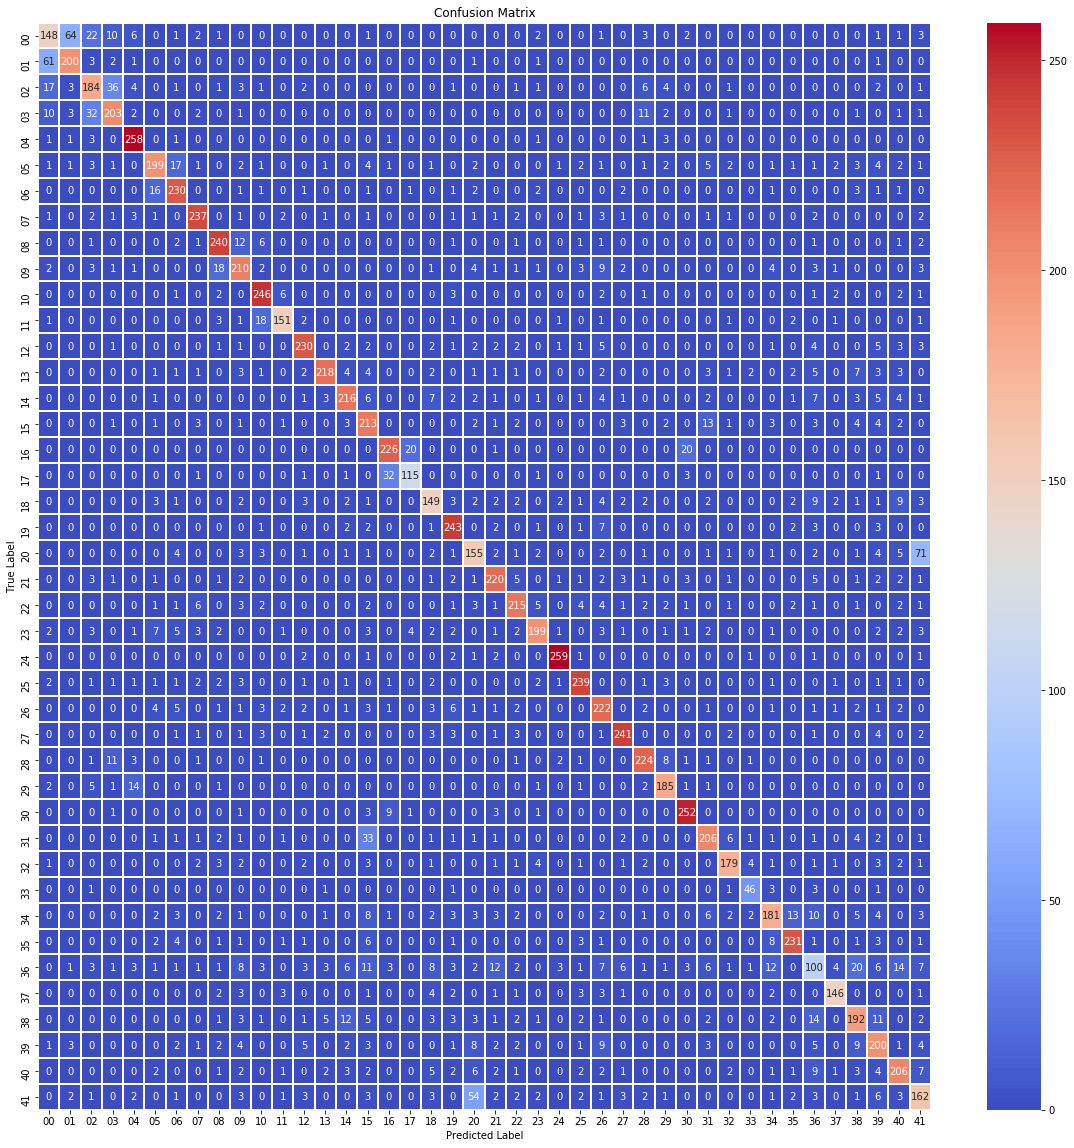

In [14]:
matrix = metrics.confusion_matrix(train_df.loc[test_ids,"category"].map(classes), test_result_thresh)
plt.figure(figsize=(20, 20))
sns.heatmap(matrix,
            cmap='coolwarm',
            linecolor='white',
            linewidths=1,
            xticklabels=classes,
            yticklabels=classes,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
print(classification_report(train_df.loc[test_ids,"category"].map(classes), test_result_thresh))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       268
           1       0.72      0.74      0.73       270
           2       0.68      0.68      0.68       269
           3       0.75      0.75      0.75       270
           4       0.86      0.96      0.91       270
           5       0.82      0.75      0.78       264
           6       0.81      0.87      0.84       264
           7       0.89      0.89      0.89       266
           8       0.83      0.89      0.86       270
           9       0.75      0.78      0.76       270
          10       0.84      0.92      0.88       267
          11       0.89      0.82      0.85       184
          12       0.87      0.86      0.86       269
          13       0.92      0.81      0.86       268
          14       0.84      0.80      0.82       269
          15       0.66      0.81      0.73       263
          16       0.82      0.85      0.83       267
          17       0.82    

/anaconda_env/personal/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


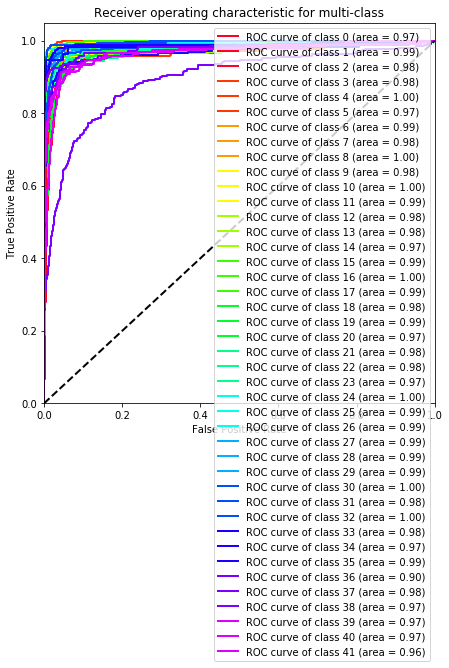

In [16]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

##plot ROC curve

classnames=[i for i in range(42)]

y_actual_binary = label_binarize(train_df.loc[test_ids,"category"].map(classes), [i for i in range(42)])
y_pred_binary = test_result_probabs
n_classes=len(classnames)
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))

cm = plt.get_cmap('gist_rainbow')
colors = cycle([cm(i//3*3.0/n_classes) for i in range(n_classes)])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

In [12]:
b4_probab = np.load("./b4_probabs.npy")#pb 78.5
b4_tpu_probab = np.load("./b4_tpu.npy")#pb 79.17
b5_tpu_probab = np.load("./b5_tpu.npy")#pb 81.578
b5_loc_probab = np.load("./b5_loc.npy")#pb 77.619
b7_probab = np.load("./b7_loc.npy")#pb 77.5
b7_tpu_probab = np.load("./b7_tpu.npy")#pb 75
b6_probab = np.load("./b6_probab.npy")#pb 76.8
ensem_sub = sub_test_df[["filename","category"]].copy()
ensem_sub.loc[:,"category"] = (
                                (b6_probab)+
                               (b7_probab*1.01)+
                               #(b7_tpu_probab*0.99)+
                               (b5_tpu_probab*1.06)+
                                #(b5_loc_probab) +
                                #(b4_probab*1.01)+
                                (b4_tpu_probab*1.02)
                              ).argmax(axis=1)
ensem_sub.loc[:,"category"] = ensem_sub.loc[:,"category"].apply(lambda x: str(x).zfill(2))
temp=ensem_sub.merge(sub_test_df, on = "filename")
temp[temp["category_x"]!=temp["category_y"]]

,filename,category_x,category_y,path
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20,None,/home/hdfsf10n/eng/model_lfs/input/test/test/f...
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27,None,/home/hdfsf10n/eng/model_lfs/input/test/test/c...
2,127f3e6d6e3491b2459812353f33a913.jpg,04,None,/home/hdfsf10n/eng/model_lfs/input/test/test/1...
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22,None,/home/hdfsf10n/eng/model_lfs/input/test/test/5...
4,46d681a542f2c71be017eef6aae23313.jpg,12,None,/home/hdfsf10n/eng/model_lfs/input/test/test/4...
...,...,...,...,...
12181,5ba958eacb23cd7d1673bad4dae55784.jpg,16,None,/home/hdfsf10n/eng/model_lfs/input/test/test/5...
12182,efbe41a1c2b666b70e337e438559808b.jpg,19,None,/home/hdfsf10n/eng/model_lfs/input/test/test/e...
12183,79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg,13,None,/home/hdfsf10n/eng/model_lfs/input/test/test/7...
12184,ac3d136124617637a05ba66694e381ef.jpg,15,None,/home/hdfsf10n/eng/model_lfs/input/test/test/a...


In [13]:
ensem_sub.to_csv("ensemble_sub.csv",index=False)